# 1. Load some packages

In [82]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Clean and merge 311 complaint data and stabilization status data

In [34]:
data = pd.read_csv('http://taxbills.nyc/joined.csv',
                   usecols = ['borough', 'ucbbl', '2007uc',
                              '2008uc', '2009uc', '2010uc',
                              '2011uc', '2012uc', '2013uc',
                              '2014uc', 'cd', 'zipcode',
                              'unitsres'])
    
#
# Make a new row for each year
#
mdata = pd.melt(data, id_vars = ['borough', 'ucbbl', 'cd', 'zipcode',
                                 'unitsres'])
mdata.rename(columns = {'variable': 'year',
                        'value': 'Nstabilized'}, inplace = True)
mdata['year'] = mdata.apply(lambda x: np.int64(x.year[0:4]), axis = 1)

    
#
# Get rid of location identifiers that you're not interested in
#     for now
#
mdata.drop(['borough', 'ucbbl', 'cd'], axis = 1,
            inplace = True)
     
mdata = mdata.groupby(['zipcode', 'year']).sum().reset_index()

mdata['Pstabilized'] = mdata['Nstabilized'] / mdata['unitsres']


mdata.drop(['unitsres'], axis = 1, inplace = True)

In [35]:
mdata.head()

,zipcode,year,Nstabilized,Pstabilized
0,10001,2007,5195,0.532329
1,10001,2008,5222,0.535096
2,10001,2009,4703,0.481914
3,10001,2010,4628,0.474229
4,10001,2011,4835,0.495440


In [36]:
  
#
# Drop values with NA zipcodes
#
print(mdata.shape)
mdata.dropna(inplace = True)
print(mdata.shape)
mdata['zipcode'] = mdata['zipcode'].astype(int)
mdata['Nstabilized'] = mdata['Nstabilized'].astype(int)
print(mdata.dtypes)

#
# Save to CSV
#
mdata.to_csv('stabilized.csv', index = False)
    

(1416, 4)
(1406, 4)
zipcode          int64
year             int64
Nstabilized      int64
Pstabilized    float64
dtype: object


In [89]:
mdata.head(10)

,zipcode,year,Nstabilized,Pstabilized
0,10001,2007,5195,0.532329
1,10001,2008,5222,0.535096
2,10001,2009,4703,0.481914
3,10001,2010,4628,0.474229
4,10001,2011,4835,0.495440
5,10001,2012,5514,0.565017
6,10001,2013,5228,0.535711
7,10001,2014,5032,0.515627
8,10002,2007,9567,0.819935
9,10002,2008,9356,0.801851


In [88]:
data = pd.read_csv('data/311_Heat_Seek_Subset.csv', 
                   usecols = [1, 5, 8], header = None)
data.rename(columns = {1: 'year', 5: 'complaint_type', 8: 'zipcode'}, inplace = True)
data['year'] = data['year'].apply(lambda x: x[6:10])
data = data.groupby(['zipcode', 'year']).count().reset_index()
data.rename(columns = {'complaint_type': 'complaint_count'}, inplace = True)

data['year'] = data['year'].astype(np.int64)
data['zipcode'] = data['zipcode'].astype(np.int64)

data.head(10)

,zipcode,year,complaint_count
0,10001,2010,648
1,10001,2011,468
2,10001,2012,344
3,10001,2013,289
4,10001,2014,437
5,10001,2015,270
6,10002,2010,1226
7,10002,2011,1244
8,10002,2012,1264
9,10002,2013,1214


In [39]:
print(data.dtypes)
print(mdata.dtypes)

zipcode            int64
year               int64
complaint_count    int64
dtype: object
zipcode          int64
year             int64
Nstabilized      int64
Pstabilized    float64
dtype: object


In [40]:
merge_data = pd.merge(data, mdata, how = 'inner', on = ['zipcode', 'year'])
merge_data.head()

,zipcode,year,complaint_count,Nstabilized,Pstabilized
0,10001,2010,648,4628,0.474229
1,10001,2011,468,4835,0.495440
2,10001,2012,344,5514,0.565017
3,10001,2013,289,5228,0.535711
4,10001,2014,437,5032,0.515627


In [71]:
ind = np.where(np.isinf(merge_data['Pstabilized']))
ind
merge_data.iloc[255]
merge_data.drop(merge_data.index[np.where(np.isinf(merge_data['Pstabilized']))], inplace = True)
ind = np.where(np.isinf(merge_data['Pstabilized']))
ind

(array([], dtype=int64),)

In [72]:
merge_data.to_csv('jointdata.csv')

In [73]:
output_json = {}
output_json['type'] = 'zipcode_data_collection'
output_json['features'] = []

for zc in np.unique(merge_data['zipcode'].values):
    entry = {}
    entry['zipcode'] = zc
    
    entry['data'] = []
    hold = merge_data[merge_data.zipcode == zc]
    for ind, row in hold.iterrows():
        data_entry = {}
        data_entry['year'] = row['year']
        data_entry['complaint_count'] = row['complaint_count']
        data_entry['percent_stabilized'] = row['Pstabilized']
        data_entry['number_stabilized'] = row['Nstabilized']
        entry['data'].append(data_entry)
        
    output_json['features'].append(entry)

In [74]:
with open('jointdata.json', 'w') as f:
    json.dump(output_json, f)

# 2. Plot the data

In [144]:
income = pd.read_csv('data/incomes.csv')
income = income[income.key == 'gross income']
income.drop(['key', 'activitythrough'], axis = 1, inplace = True)
income.rename(columns = {'bbl': 'ucbbl', 'value': 'income'}, inplace = True)

data = pd.read_csv('http://taxbills.nyc/joined.csv',
                   usecols = ['borough', 'ucbbl', '2007uc',
                              '2008uc', '2009uc', '2010uc',
                              '2011uc', '2012uc', '2013uc',
                              '2014uc', 'cd', 'zipcode',
                              'unitsres', 'yearbuilt'])

    
#
# Make a new row for each year
#
mdata = pd.melt(data, id_vars = ['borough', 'ucbbl', 'cd', 'zipcode',
                                 'unitsres', 'yearbuilt'])
mdata.rename(columns = {'variable': 'year',
                        'value': 'Nstabilized'}, inplace = True)
mdata['year'] = mdata.apply(lambda x: np.int64(x.year[0:4]), axis = 1)


mdata = pd.merge(mdata, income, how = 'inner', on = ['ucbbl', 'year'])

mdata['norm_income'] = mdata['income'] / mdata['unitsres']


mn = np.mean(mdata.norm_income[np.isfinite(mdata.norm_income)])
sd = np.std(mdata.norm_income[np.isfinite(mdata.norm_income)])

mdata = mdata[(mdata.yearbuilt <= 1948) & (mdata.norm_income < mn)]
    
#
# Get rid of location identifiers that you're not interested in
#     for now
#
mdata.drop(['borough', 'ucbbl', 'cd', 'yearbuilt', 'income'], axis = 1,
            inplace = True)
     

mdata = mdata.groupby(['zipcode', 'year']).sum().reset_index()


mdata['Pstabilized'] = mdata['Nstabilized'] / mdata['unitsres']

mdata.drop(['unitsres'], axis = 1, inplace = True)
mdata.head()

,zipcode,year,Nstabilized,norm_income,Pstabilized
0,10001,2007,780,521641.226998,0.568928
1,10001,2008,624,466587.629292,0.564706
2,10001,2009,414,378397.550364,0.610619
3,10001,2010,356,364789.266504,0.590381
4,10001,2011,314,282443.368031,0.603846


In [145]:
  
#
# Drop values with NA zipcodes
#
print(mdata.shape)
mdata.dropna(inplace = True)
print(mdata.shape)
mdata['zipcode'] = mdata['zipcode'].astype(int)
mdata['Nstabilized'] = mdata['Nstabilized'].astype(int)
print(mdata.dtypes)

#
# Save to CSV
#
mdata.to_csv('stabilizedpre1948.csv', index = False)
mdata.head(23)

(1203, 5)
(1191, 5)
zipcode          int64
year             int64
Nstabilized      int64
norm_income    float64
Pstabilized    float64
dtype: object


,zipcode,year,Nstabilized,norm_income,Pstabilized
0,10001,2007,780,521641.226998,0.568928
1,10001,2008,624,466587.629292,0.564706
2,10001,2009,414,378397.550364,0.610619
3,10001,2010,356,364789.266504,0.590381
4,10001,2011,314,282443.368031,0.603846
5,10001,2012,258,240511.568888,0.537500
6,10001,2013,313,264398.954663,0.573260
7,10001,2014,289,276440.027350,0.543233
8,10002,2007,5357,3705195.742442,0.820870
9,10002,2008,5031,3515309.470261,0.819381


In [146]:
data = pd.read_csv('data/311_Heat_Seek_Subset.csv', 
                   usecols = [1, 5, 8], header = None)
data.rename(columns = {1: 'year', 5: 'complaint_type', 8: 'zipcode'}, inplace = True)
data['year'] = data['year'].apply(lambda x: x[6:10])
data = data.groupby(['zipcode', 'year']).count().reset_index()
data.rename(columns = {'complaint_type': 'complaint_count'}, inplace = True)

data['year'] = data['year'].astype(np.int64)
data['zipcode'] = data['zipcode'].astype(np.int64)

data.head(10)

,zipcode,year,complaint_count
0,10001,2010,648
1,10001,2011,468
2,10001,2012,344
3,10001,2013,289
4,10001,2014,437
5,10001,2015,270
6,10002,2010,1226
7,10002,2011,1244
8,10002,2012,1264
9,10002,2013,1214


In [147]:
merge_data = pd.merge(data, mdata, how = 'inner', on = ['zipcode', 'year'])
merge_data.head()

,zipcode,year,complaint_count,Nstabilized,norm_income,Pstabilized
0,10001,2010,648,356,364789.266504,0.590381
1,10001,2011,468,314,282443.368031,0.603846
2,10001,2012,344,258,240511.568888,0.537500
3,10001,2013,289,313,264398.954663,0.573260
4,10001,2014,437,289,276440.027350,0.543233


In [150]:
hold = merge_data.groupby('year').mean().reset_index()
hold.head()

,year,zipcode,complaint_count,Nstabilized,norm_income,Pstabilized
0,2010,10801.965986,1424.503401,3305.619048,1926018.968000,0.722371
1,2011,10802.852349,1253.845638,3185.040268,1902848.609268,0.753470
2,2012,10796.728571,1264.621429,1932.692857,713985.821440,0.764863
3,2013,10813.480263,1249.572368,3106.039474,1864972.924937,0.743447
4,2014,10791.333333,1527.673469,2961.210884,1828221.311653,0.728671


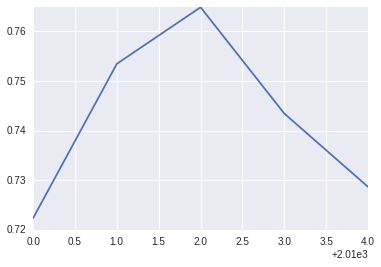

In [151]:
plt.plot(hold['year'], hold['Pstabilized'])